In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import rtmidi
from time import sleep
from collections import deque

%matplotlib inline
plt.style.use('default')

In [2]:
def imshow(*args, **kwargs):
    plt.figure()
    plt.imshow(*args, **kwargs)
    plt.show()

In [3]:
CAMERA_MATRIX = np.array([[722.47843533, 0., 345.76148326], [0., 719.46836039, 215.29777186], [0., 0., 1.]])
DIST_COEFFS = np.array([[ 0.060491, -0.16982899, 0.00052914, 0.00505482, 0.31064351]])

MARKER_DICT = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
# MARKER_LENGTH = 0.34  # Physical marker length size
MARKER_LENGTH = 0.165  # Physical marker length size

# Define what index marker to detect keypress on
MARKER_ID = 8

# X rotation history window
HIST_LENGTH = 4

# Required rotation in degrees for keypress event
MIN_ROTATION_FOR_KEY_PRESS = 0.05

# Minimum velocity returned by keypress
MIN_KEY_VELOCITY = 60

# Show extra debug info in frame
DEBUG = True

RED = (28,26,228)
BLUE = (184,126,55)
GREEN = (74,175,77)
PURPLE = (163,78,152)
ORANGE = (0,127,255)

## ARUCO Util Functions

In [4]:
def gen_aruco_markers(size, columns, rows):
    
    fig = plt.figure(figsize=(8, 8))
    
    for i in range(1, columns*rows +1):
        marker = cv2.aruco.drawMarker(MARKER_DICT, i, size)    
        
        ax = fig.add_subplot(rows, columns, i)
        ax.axis('off')
        plt.imshow(marker, cmap='gray')
    
    plt.show()

    
def detect_markers(img):
    """Returns corners, ids, rejectedImgPoints."""
    return cv2.aruco.detectMarkers(img, MARKER_DICT)


class Id2Idx(object):
    """Map between aruco ids and the index in the list of detected corners, ids returned by detect_markers."""
    def __init__(self, ids):
        self._id2idx = dict([(id_[0], idx) for idx, id_ in enumerate(ids.tolist())])
        self._idx2id = dict([(idx, id_[0]) for idx, id_ in enumerate(ids.tolist())]) 
        
    def get_id(self, idx):
        """Get the corresponding id at idx in list ids given in class constructor."""
        return self._idx2id.get(idx, None)
    
    def get_idx(self, id_):
        """Get the corresponding index of id_ in list ids given in class constructor."""
        return self._id2idx.get(id_, None)
    

def draw_markers(img, corners, ids=None):
    """Returns img with markers drawn."""
    return cv2.aruco.drawDetectedMarkers(img, corners, ids)


def estimate_marker_pose(corners):
    """returns rvecs, tvecs, _objPoints."""
    return cv2.aruco.estimatePoseSingleMarkers(corners, MARKER_LENGTH, CAMERA_MATRIX, DIST_COEFFS)


def draw_axis(img, rvec, tvec):
    """Draw the pose estimate on the img."""
    return cv2.aruco.drawAxis(img, CAMERA_MATRIX, DIST_COEFFS, rvec, tvec, MARKER_LENGTH)


def draw_axes(img, rvecs, tvecs):
    """Draw multiple post estimates on the img."""
    for r, t in zip(rvecs, tvecs):
            draw_axis(img, r, t)

            
def r2d(rad):
    """Convert radians to degrees"""
    return rad * 180 / np.pi

def d2r(deg):
    """Convert degrees to radians"""
    return deg / 180 * np.pi

In [5]:
# gen_aruco_markers(200, 4, 5)

## MIDI Util function

In [6]:
def open_midi_out_virtual_port(api=rtmidi.RtMidiOut.UNIX_JACK, clientName="PyMIDI"):
    """Open a midiout port."""
    # Initialize midi out port
    midiout = rtmidi.RtMidiOut(api=api, clientName=clientName)
    
    # Print some debug info
    ports = range(midiout.getPortCount())
    if ports:
        for i in ports:
            print(midiout.getPortName(i))
    
    # Open the virtual port
    print("Opening port 0!") 
    midiout.openVirtualPort()    
    return midiout
           
    
def program_change(midiout, channel, program):
    """Change the MIDI program (virtual instrument)."""
    msg = rtmidi.MidiMessage.programChange(channel, 1)
    midiout.sendMessage(msg)
    
    
def controller_event(midiout, channel, controller, level):
    """Change controller to have level."""
    msg = rtmidi.MidiMessage.controllerEvent(channel, controller, level)
    midiout.sendMessage(msg)
    
    
def volume_change(midiout, channel, level):
    """Change volume to level."""
    controller_event(midiout, channel, 7, level)
    
    
def play_note_on(midiout, channel, note, velocity):
    """Play note with id note with given velocity until shutoff."""
    msg = rtmidi.MidiMessage.noteOn(channel, note, velocity)
    midiout.sendMessage(msg)
    
    
def play_note_off(midiout, channel, note):
    """Shutoff note with id note."""
    msg = rtmidi.MidiMessage.noteOff(channel, note)
    midiout.sendMessage(msg)
    
    
def play_note(midiout, channel, note, velocity, time=1):
    """Play note with id note with given velocity for time seconds."""
    play_note_on(midiout, channel, note, velocity)
    sleep(time)
    play_note_off(midiout, channel, note)

## Setup MIDI output port

In [7]:
midiout = open_midi_out_virtual_port()

# Define channel
channel = 1

# Sound out a series of MIDI messages
program_change(midiout, channel, 12)

# Control change (volume)
volume_change(midiout, channel, 100)

Midi Through 14:0
Opening port 0!


# Video capture loop

### Determine keypresses using running history queue

In [8]:
class KeypressHistory(object):
    def __init__(self, hist_length):
        super(KeypressHistory, self).__init__()
        self.hist_length = hist_length
        self.q = deque([0] * hist_length)
        self.prev_x_down = [False] * hist_length
        self.prev_x_up = [True] * hist_length
        self.velocity = 0  # default
        self.key_is_down = False  # Track current state of key
        
    def key_down_event(self):
        """Return true if keypress down event occured given current history."""
        if self.hist_length > 2:
            # New keydown event if last two x down and all up in prev history
            return self.prev_x_down[-2] and all(self.prev_x_up[:-2])
        elif self.hist_length > 1:
            # New keydown event if last x is down and all up in prev history
            return self.prev_x_down[-1] and all(self.prev_x_up[:-1])
        elif self.hist_length == 1:
            return self.prev_x_down[0]
        else:
            print("HIST_LENGTH must be >= 1")
            return False

    def key_up_event(self):
        """Return true if keypress up event occured given current history."""
        if self.hist_length > 0:
            # New keydown event if last x is up
            return self.prev_x_up[-1]
        else:
            print("HIST_LENGTH must be >= 1")
            return False
    
    def key_down_velocity(self):
        """Return velocity of key down given current history."""
        return self.velocity
    
    def save(self, x_rot):
        """Save a new x_rot in the queue history."""       
        # Update queue
        self.q.popleft()
        self.q.append(x_rot)
        
        # Update down and up history
        self.prev_x_down = [x > MIN_ROTATION_FOR_KEY_PRESS for x in self.q]
        self.prev_x_up = [not x for x in self.prev_x_down]
        
        # Update current state of key using history
        if self.key_down_event():
            self.key_is_down = True
            self.key_is_up = False
            self.velocity = int(round(x_rot * (127 - MIN_KEY_VELOCITY))) + MIN_KEY_VELOCITY
        elif self.key_up_event():
            self.key_is_down = False
            self.key_is_up = True
            

def get_press_level(x, x_init):
    """Map periodic angles in [0,90] to range [0,1]."""
    # Adjust measured rotation based on initial position
    x_rot = x_init - x + 1e-5
    return (1 - np.cos(d2r(x_rot * 2))) / 2

### Define dict mapping ARuco IDs to callback functions

In [20]:
# Dict mapping ARuco IDs to notes and for storing initial key angles and other state info
# scale = [2, 2, 1, 2, 2, 2, 1]  # major
# scale = [2, 1, 2, 2, 1, 2, 2]  # minor
scale = [2, 2, 1, 2, 2]  # 6 note

def note_gen(k, scale):
    yield k
    curr = k
    scale.reverse()
    while len(scale):
        curr += scale.pop()
        yield curr
        
KEY = 48 #C4
notes = [n for n in note_gen(KEY, scale)]
key_config = dict((str(i + 1), {'note': n}) for i, n in enumerate(notes))


# Initialize function. Callback for when spacebar pressed
def initialize(marker_id, corners, rvec, tvec, frame):
    """Callback function for initialization of keyboard on spacebar press."""
    # Check that marker has config
    m = str(marker_id)
    if marker_id is None or not m in key_config.keys():
        return frame
    
    # Calculate rotation angle in range [-180, 180]
    x, y, z = [r2d(d) for d in rvec]
    
    # Save initialization in config (state)
    config = key_config[m] 
    config['key_history'] = KeypressHistory(HIST_LENGTH)
    config['init_x'] = x

    return frame


# Callback function. Processing logic for individual frames. Includes key pose and more
def callback(marker_id, corners, rvec, tvec, frame):
    """Callback to handle any other video frame for marker with id marker_id."""
    # Check that marker has config
    m = str(marker_id)
    if marker_id is None or not m in key_config.keys():
        return frame
     
    # Calculate rotation angle in range [-180, 180]
    x, y, z = [r2d(d) for d in rvec]
    
    # Get state variables
    config = key_config[m]
    init_x = config.get('init_x', 0)
    note = config.get('note', 48)
    history = config.get('key_history', False)
    if not history:
        initialize(marker_id, corners, rvec, tvec, frame)
        history = config.get('key_history')
    
    # Calculate how pressed down the key is and save to history
    press_level = get_press_level(x, init_x)
    history.save(press_level)
    
    # Write the rotation and color the marker
    poly_color = GREEN if history.key_is_down else RED
    text_color = RED if history.key_is_down else GREEN
    int_corners = np.array(corners, dtype='int32')
    cv2.fillConvexPoly(frame, np.array(corners, dtype='int32'), poly_color)
    cv2.putText(frame, "%.2f" % press_level, tuple(int_corners[-1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color)
    
    # Handle down/up transition events
    if history.key_down_event():       
        # Turn MIDI note on
        velocity = history.key_down_velocity()
        play_note_on(midiout, channel, note=note, velocity=velocity)
        
    elif history.key_up_event():
        # Turn MIDI note off
        play_note_off(midiout, channel, note=note)
    
    return frame

In [ ]:
# Camera parameters
height = 480
width = 640
fps = 60
autofocus = 1  # off
    
# setup capture
camera = cv2.VideoCapture(0)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, width)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
camera.set(cv2.CAP_PROP_FPS, fps)
camera.set(cv2.CAP_PROP_AUTOFOCUS, autofocus)

# Initial rotation state
init_set = False
        
# capture loop
while True:
    # Get keyboard input
    k = cv2.waitKey(1) 
    
    # get frame
    ret, frame = camera.read()   
    
    # detect aruco markers
    corners, ids, rejects = detect_markers(frame)

    markers_detected = ids is not None
        
    if markers_detected:
        # Get pose estimates
        rvecs, tvecs, _ = estimate_marker_pose(corners)  

        # Utility to map marker ids to indexes of corresponding corners, rvecs, tvecs
        id2idx = Id2Idx(ids)
        
        if not init_set:
            draw_markers(frame, corners, ids)
#             draw_axes(frame, rvecs, tvecs)
            cv2.putText(frame, "Press spacebar to set initial key poses", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, [0,0,255])
                
        for marker_id in ids:                
            marker_id = marker_id[0]

            # Get the index of the corresponding rvecs, tvecs
            marker_idx = id2idx.get_idx(marker_id)            
            
            if marker_idx is None:
                continue
            
            rvec = rvecs[marker_idx][0]
            tvec = tvecs[marker_idx][0]
            corner = corners[marker_idx][0]
        
            if k == 32:  # spacebar hit
                initialize(marker_id, corners, rvec, tvec, frame)
                init_set = True
            elif init_set:
                callback(marker_id, corner, rvec, tvec, frame)
                
            
        draw_axes(frame, rvecs, tvecs)
            
    # Show frames
    cv2.imshow('frame', frame)
    
    # quit on q 
    if k & 0xFF == ord('q'):
        break
    elif k & 0xFF == ord('p'):
        cv2.imwrite('arucoframe.png', frame)

# clean upq
camera.release()
cv2.destroyAllWindows()
cv2.waitKey(1)  # extra waitKey sometimes needed to close camera window

In [ ]:
midiout.closePort()  # TODO: Doesn't seem to work?

Debug chart to map key angles to keypress strength

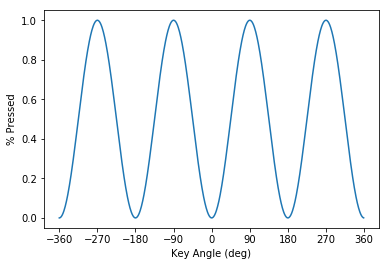

In [12]:
init_angle = 0
mind, maxd = -360, 360
xs = [x for x in range(mind, maxd)]
c = [(1 - np.cos(d2r((init_angle - x) * 2))) / 2 for x in xs]
plt.xlabel('Key Angle (deg)')
plt.ylabel('% Pressed')
plt.xticks(np.arange(mind, maxd+1, 90))
plt.plot(xs, c)